In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling as yd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import  OneHotEncoder,StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import yeojohnson, boxcox, zscore
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import joblib


In [9]:
# Import data
expresso_churn= pd.read_csv("Expresso_churn_dataset.csv")
expresso_churn.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


In [10]:
# Quick overview
# Drop ID and MRG since it only has 1 value
df= expresso_churn.drop(columns=["user_id", "MRG"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 17 columns):
 #   Column          Dtype  
---  ------          -----  
 0   REGION          object 
 1   TENURE          object 
 2   MONTANT         float64
 3   FREQUENCE_RECH  float64
 4   REVENUE         float64
 5   ARPU_SEGMENT    float64
 6   FREQUENCE       float64
 7   DATA_VOLUME     float64
 8   ON_NET          float64
 9   ORANGE          float64
 10  TIGO            float64
 11  ZONE1           float64
 12  ZONE2           float64
 13  REGULARITY      int64  
 14  TOP_PACK        object 
 15  FREQ_TOP_PACK   float64
 16  CHURN           int64  
dtypes: float64(12), int64(2), object(3)
memory usage: 279.4+ MB


In [ ]:
# Pandas profiling report
report= yd.ProfileReport(df)
report

In [11]:
# Remove duplicates
no_dupes= df.drop_duplicates()

In [12]:
# Handle missing values
no_dupes.isna().sum()

REGION             345171
TENURE                  0
MONTANT            131656
FREQUENCE_RECH     131656
REVENUE            100120
ARPU_SEGMENT       100120
FREQUENCE          100120
DATA_VOLUME        489563
ON_NET             190467
ORANGE             254668
TIGO               646310
ZONE1             1341424
ZONE2             1373169
REGULARITY              0
TOP_PACK           260316
FREQ_TOP_PACK      260316
CHURN                   0
dtype: int64

In [13]:
def handle_missing_values(df, threshold=0.5):
  """
    Handele missing values from a Pandas DataFrame by removing rows where the column has less than threshold of missing values,
    and imputing the rest.
  """
  for col in df:
    missing_values= df[col].isnull().sum()
    missing_percentage= round(missing_values/len(df),2)
    if missing_percentage > threshold: # Drop rows if below 5% threshold
        df= df.dropna(subset=[col])
    else: # Impute when above 5%
        # Handle booleans
        uniques= set(df[col].value_counts().index) # Get uniques without NaNs
        allowed_set= {0.0,1.0,1,0} # In case column is set to float
        is_bool= all([item in allowed_set for item in uniques])
        if is_bool:
            df[col]= df[col].astype(bool)
        if df[col].dtype == 'object' or is_bool: # Impute with mode if column is categorical
            df.fillna({col: df[col].mode()[0]}, inplace=True)
        else:
            df.fillna({col: df[col].mean()}, inplace=True) # Impute with mean if column is numeric
  return df
no_dupes_missing= handle_missing_values(no_dupes)

C:\Users\Thistle\AppData\Local\Temp\ipykernel_2664\3751903658.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna({col: df[col].mode()[0]}, inplace=True)
C:\Users\Thistle\AppData\Local\Temp\ipykernel_2664\3751903658.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna({col: df[col].mode()[0]}, inplace=True)
C:\Users\Thistle\AppData\Local\Temp\ipykernel_2664\3751903658.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [14]:
no_dupes_missing.isna().sum()

REGION            0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
ZONE1             0
ZONE2             0
REGULARITY        0
TOP_PACK          0
FREQ_TOP_PACK     0
CHURN             0
dtype: int64

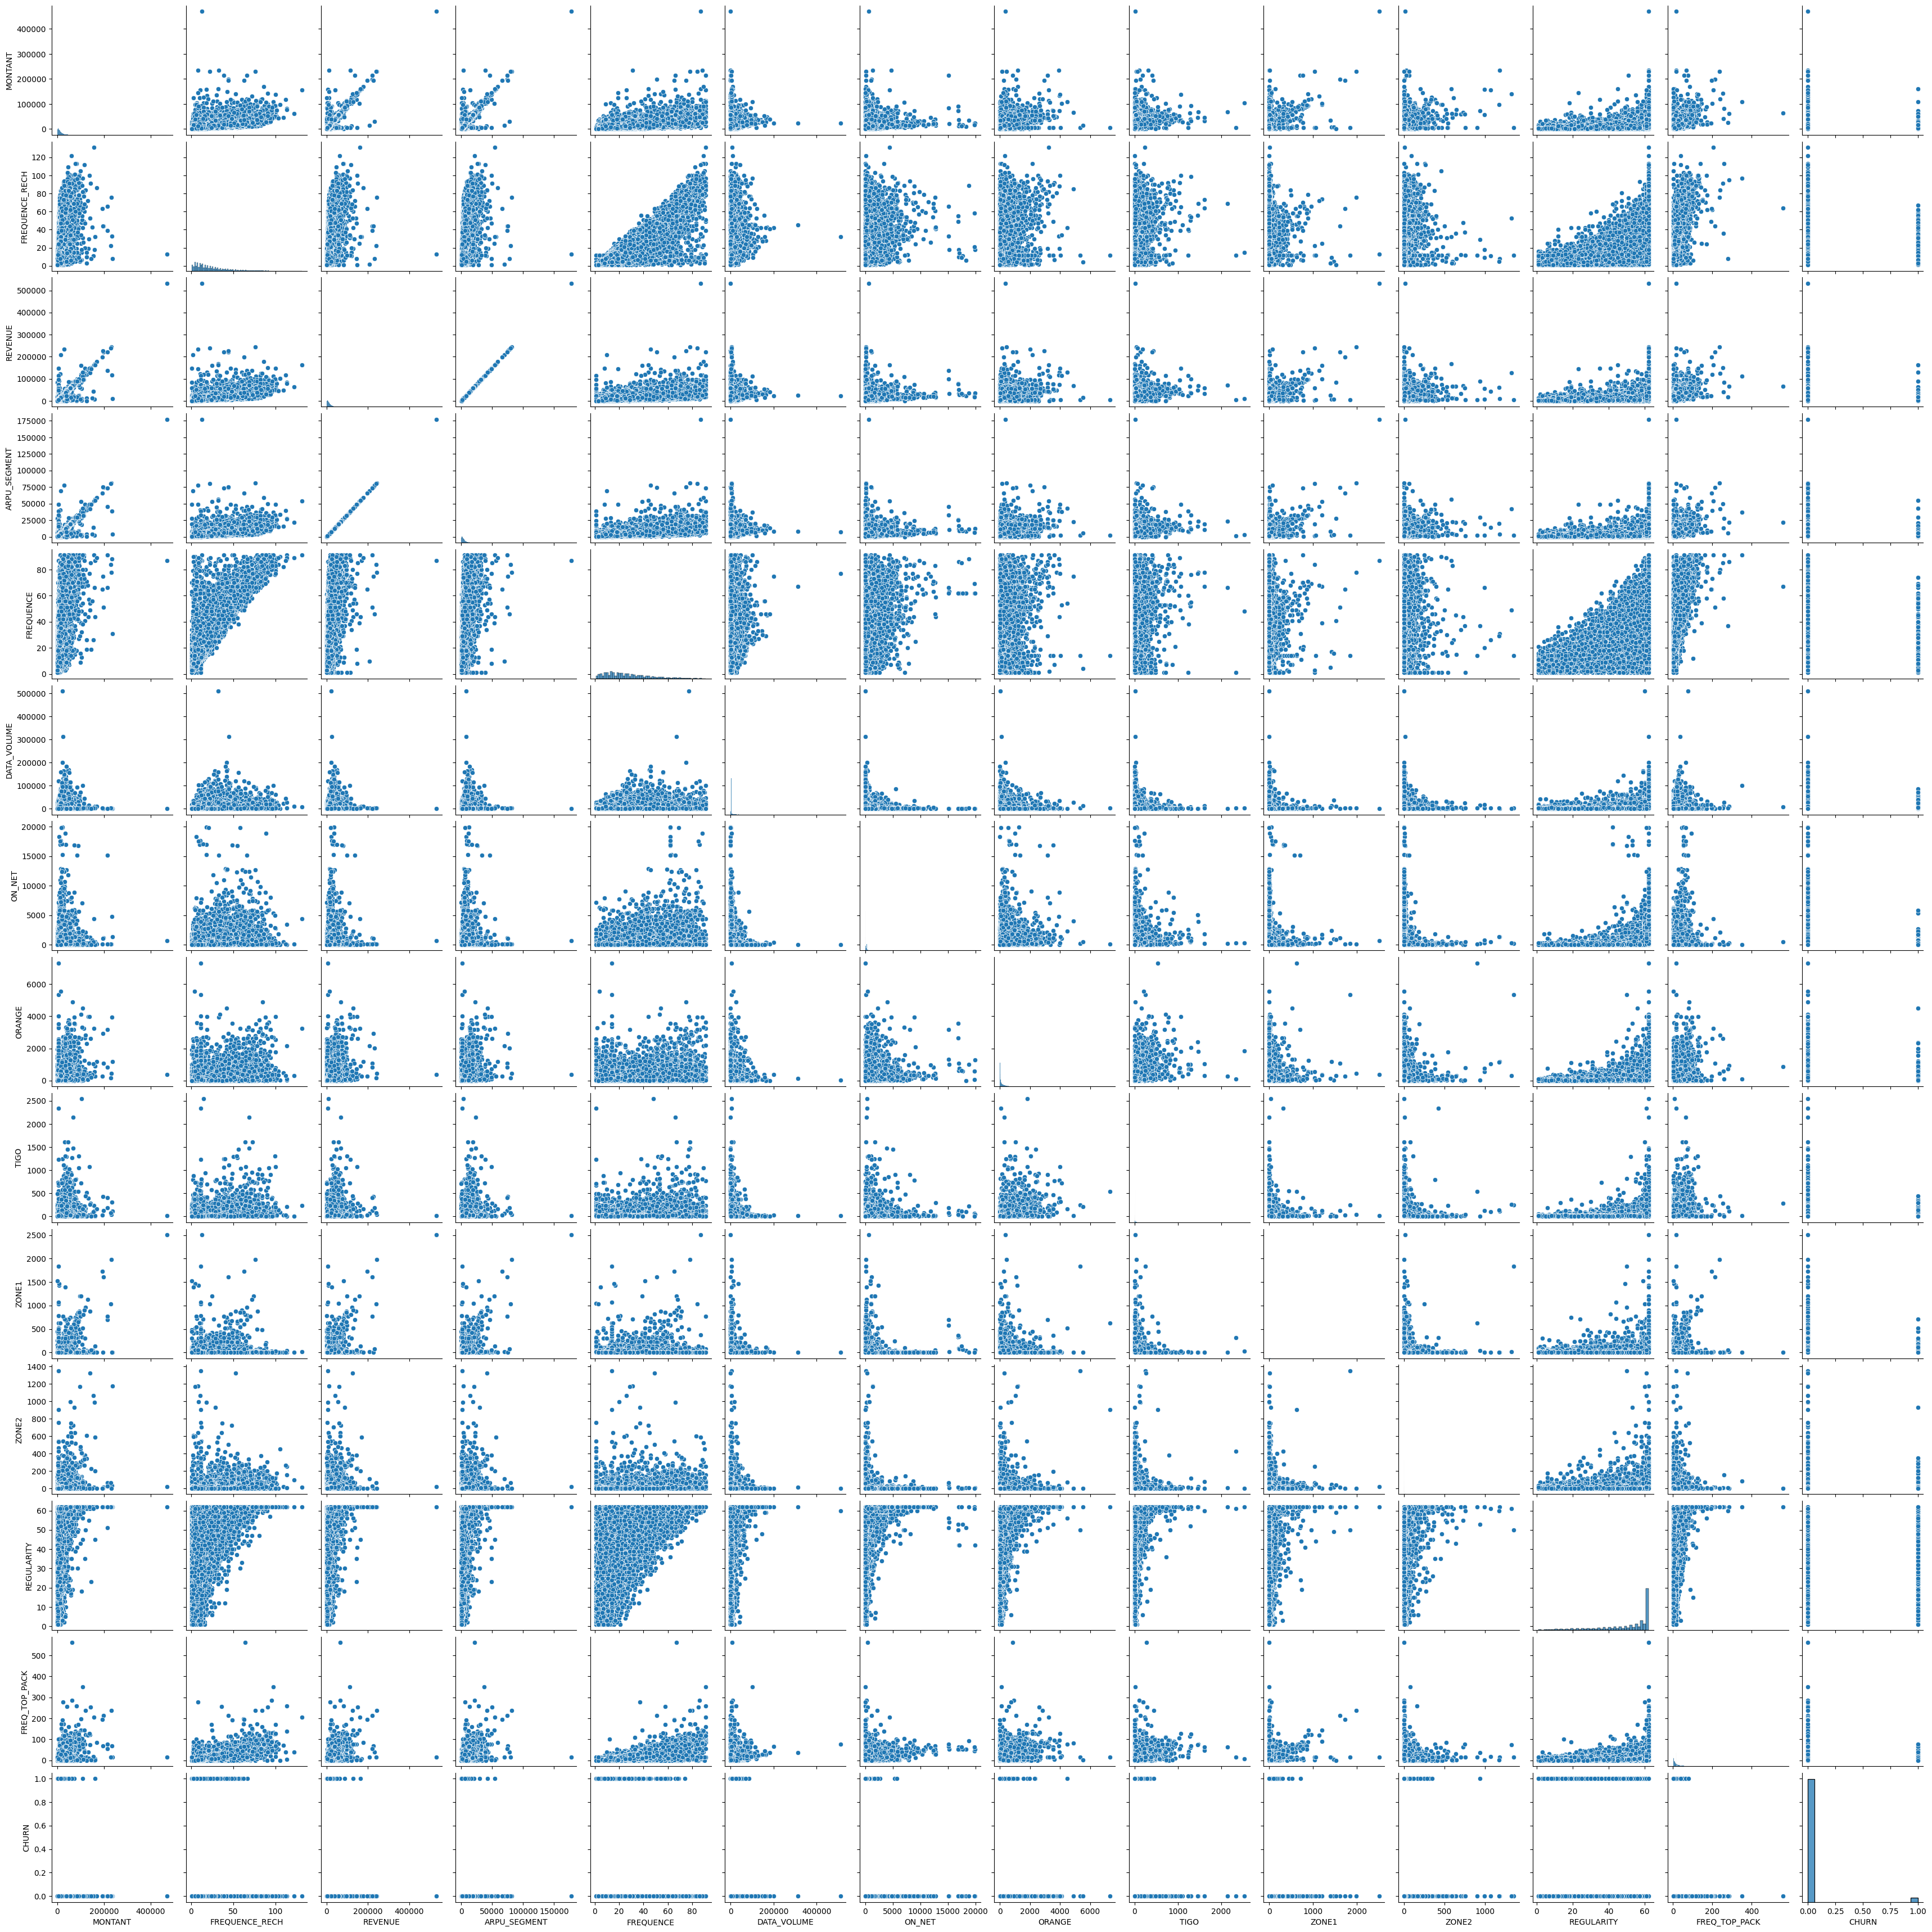

In [ ]:
# Visualise numeric data
sns.pairplot(no_dupes_missing)
plt.show()

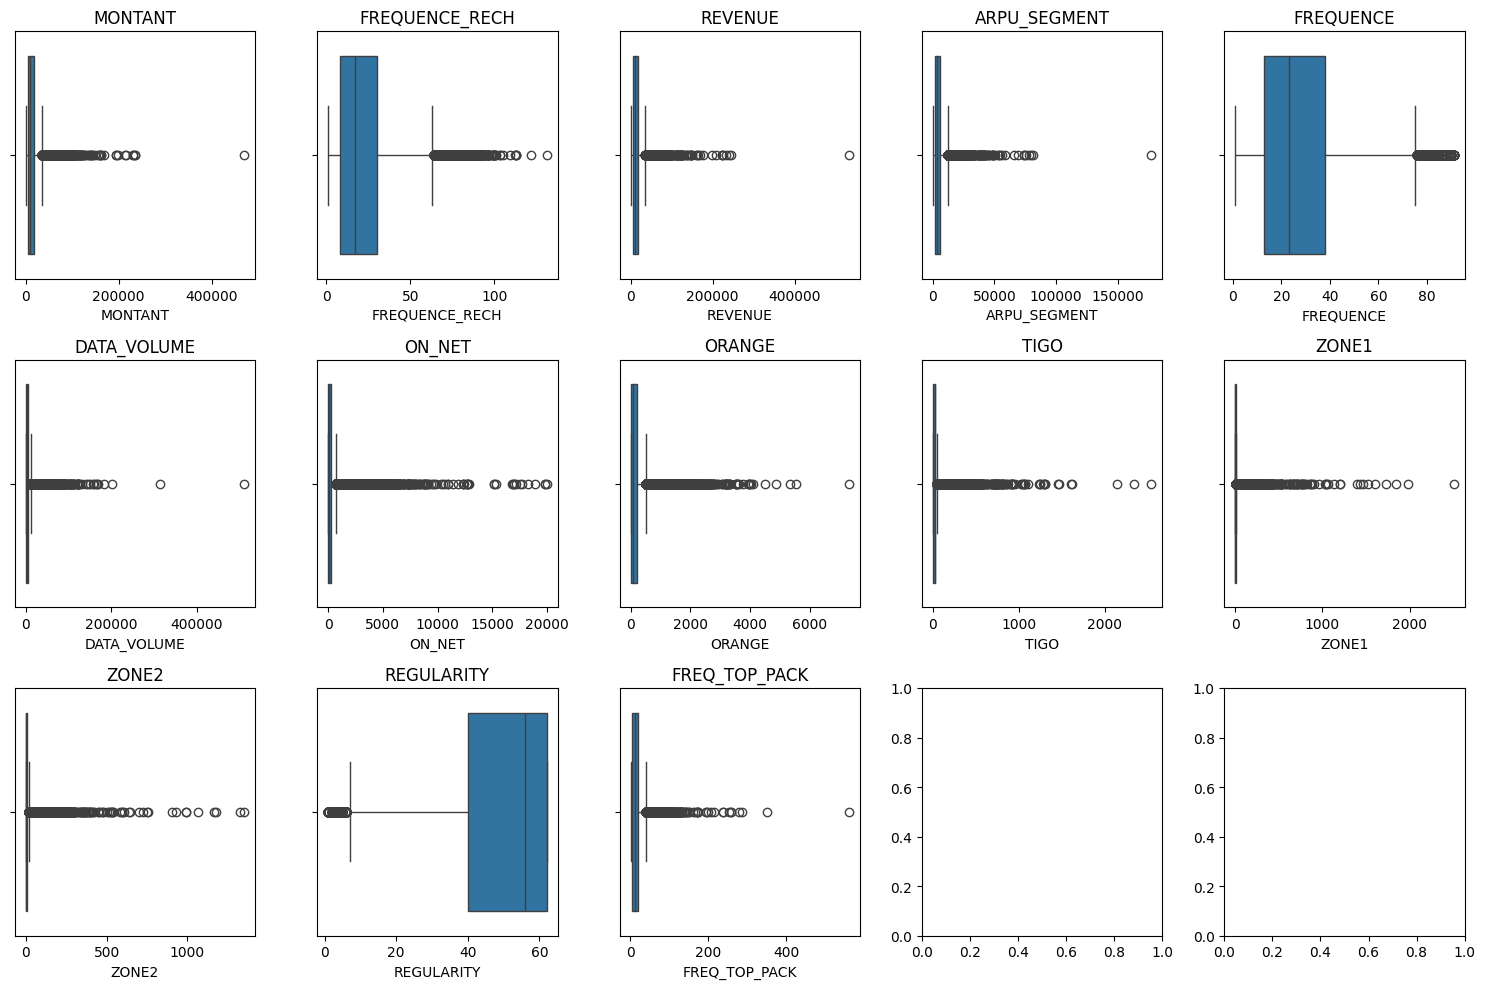

In [15]:
# Visualise boxplots for numeric columns
num_cols = [col for col in no_dupes_missing.columns if no_dupes_missing[col].dtype in ["float64", "int64"]]

def sub_boxplots(cols, data, rows=3):
  fig, axes = plt.subplots(nrows=3, ncols=int(np.ceil((len(cols)/3))), figsize=(15, 10))
  axes = axes.flatten()
  for i, col in enumerate(cols):
      sns.boxplot(x=data[col], ax=axes[i])
      axes[i].set_title(col)
  plt.tight_layout()
  plt.show()

sub_boxplots(num_cols, no_dupes_missing)

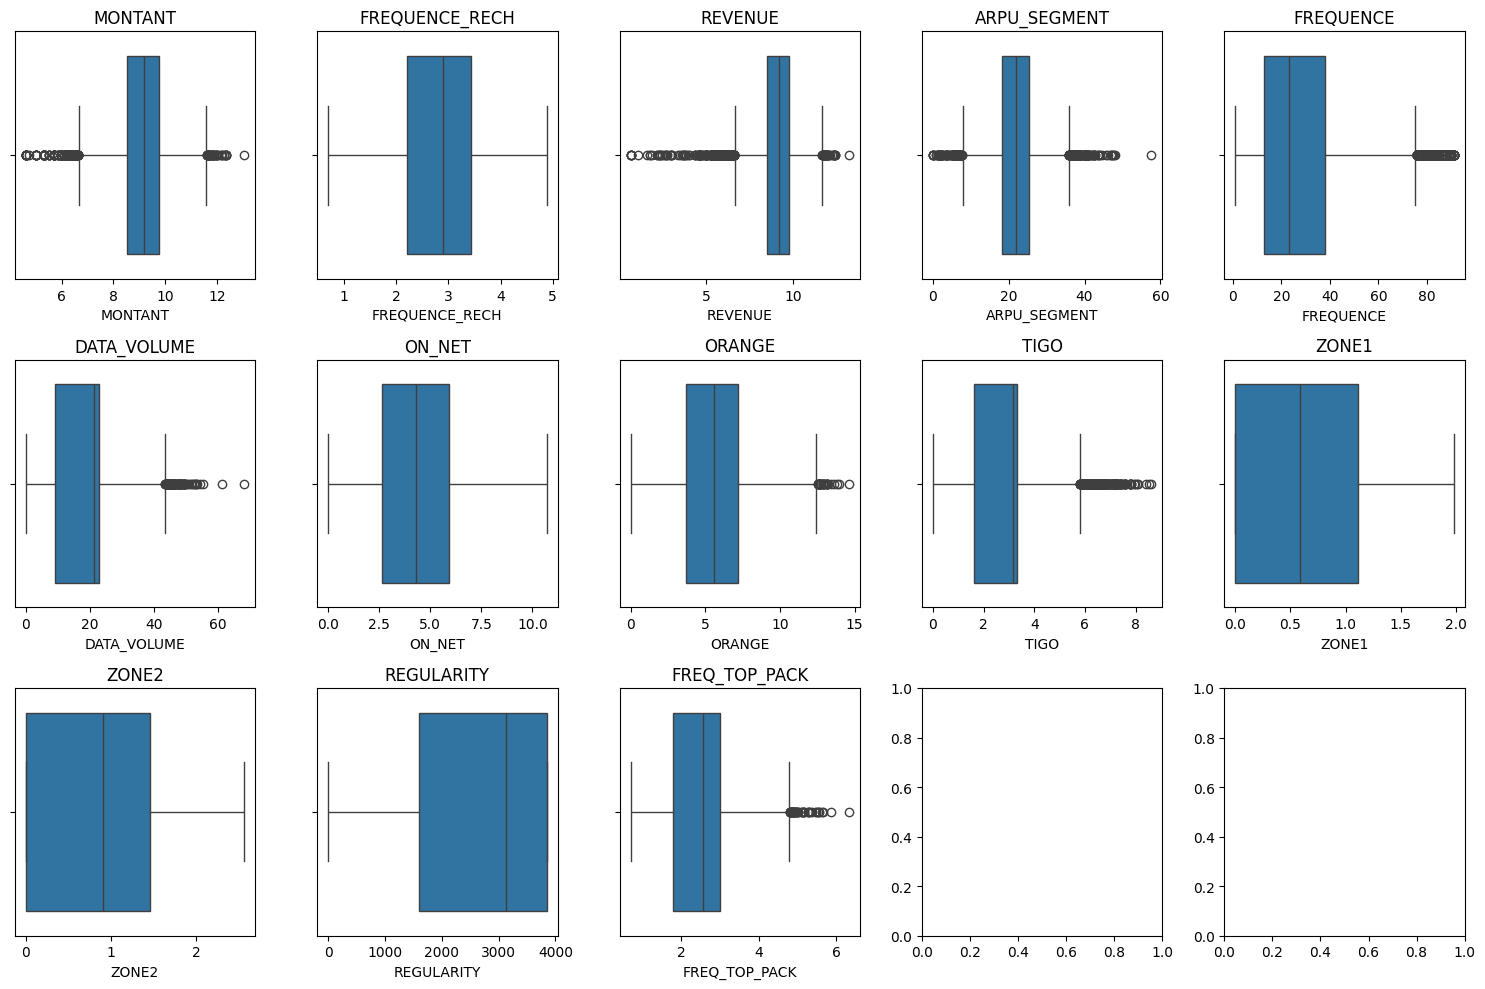

In [16]:
# Many features have extreme and skewed distributions

def handle_skewness(feature, skew_threshold=1):
    """
    Automatically handles skewness for a given pandas Series.
    - Applies appropriate transformation based on the skewness.
    - Handles positive and negative skewness differently.
    """
    skew = feature.skew()
    
    if skew > skew_threshold:  # Positively skewed
        if (feature > 0).all():  # Log transformation requires strictly positive values
            return np.log1p(feature)  # log1p is log(1 + x) to handle zero values
        else:  # Yeo-Johnson for non-positive values
            return pd.Series(yeojohnson(feature)[0], index=feature.index)
    elif skew < -skew_threshold:  # Negatively skewed
        return feature**2  # Square transformation for negative skewness
    else:  # No significant skewness
        return feature
    
guassian= no_dupes_missing.copy()
for col in num_cols:
    guassian[col]= handle_skewness(guassian[col])

sub_boxplots(num_cols,guassian)

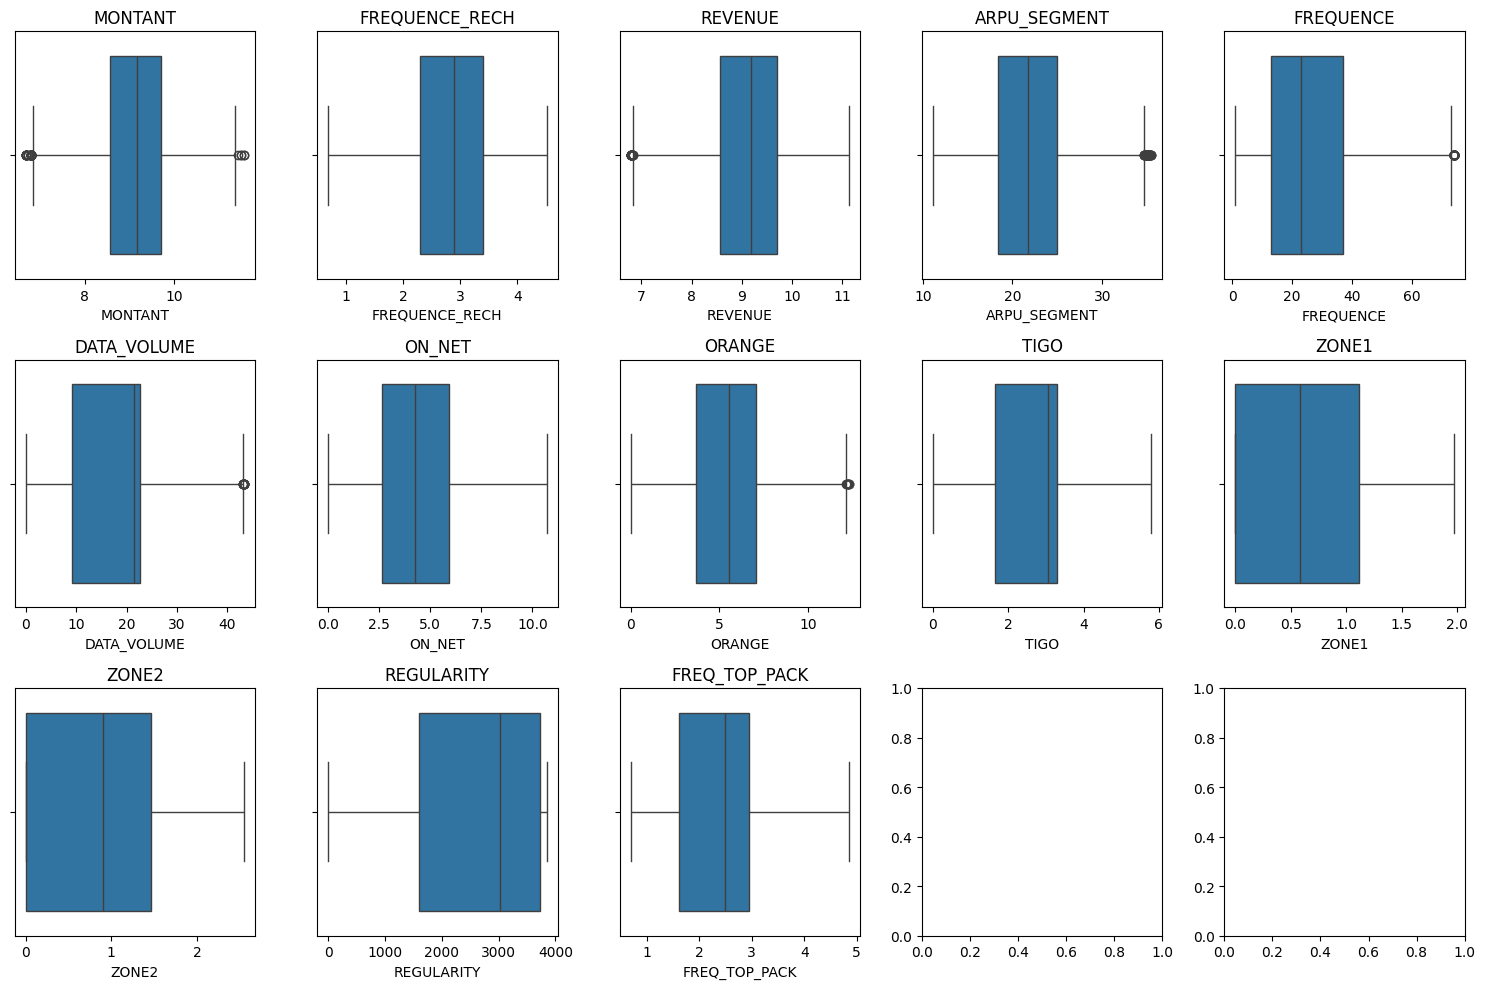

In [17]:
# Now we can handle outliers
clean_df= guassian.copy()
for col in num_cols:
    Q1= clean_df[col].quantile(0.25)
    Q3= clean_df[col].quantile(0.75)
    IQR= Q3-Q1
    lower_bound= Q1-1.5*IQR
    upper_bound= Q3+1.5*IQR
    clean_df= clean_df[(clean_df[col] >= lower_bound) & (clean_df[col] <= upper_bound)]

sub_boxplots(num_cols,clean_df)

In [18]:
cat_cols= [col for col in clean_df.columns if col not in num_cols]

print(clean_df[cat_cols[2]].value_counts())
# TOP_PACK has too many unique values to encode, therefore we drop it
clean_df= clean_df.drop(columns="TOP_PACK")

TOP_PACK
All-net 500F=2000F;5d                        8692
Data:490F=1GB,7d                             2120
On net 200F=Unlimited _call24H               1692
Data: 100 F=40MB,24H                         1497
MIXT:500F= 2500F on net _2500F off net;2d     967
                                             ... 
On-net 2000f_One_Month_100H; 30d                1
200F=10mnOnNetValid1H                           1
All-net 500F=4000F ; 5d                         1
NEW_CLIR_PERMANENT_LIBERTE_MOBILE               1
Package3_Monthly                                1
Name: count, Length: 79, dtype: int64


In [19]:
print(clean_df[cat_cols[0]].value_counts())
# Need to one-hot encode REGION

REGION
DAKAR          14976
SAINT-LOUIS     1534
THIES           1533
TAMBACOUNDA     1260
KOLDA           1015
KAOLACK          940
LOUGA            531
MATAM            465
ZIGUINCHOR       412
KAFFRINE         287
FATICK           261
DIOURBEL         254
SEDHIOU           64
KEDOUGOU          15
Name: count, dtype: int64


In [20]:
print(clean_df[cat_cols[1]].value_counts())
# Need to label encode TENURE

TENURE
K > 24 month     22440
I 18-21 month      474
H 15-18 month      226
G 12-15 month      153
F 9-12 month       115
J 21-24 month      111
E 6-9 month         24
D 3-6 month          4
Name: count, dtype: int64


In [21]:
# Feature selection

# Target
y= clean_df["CHURN"]
# Features
X= clean_df.drop(columns=["CHURN"], axis=1)

In [22]:
# Train test split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

In [23]:
# Target variable is highly imbalanced
y.value_counts(normalize=True)

CHURN
False    0.965388
True     0.034612
Name: proportion, dtype: float64

In [31]:
# Column transformer to apply one-hot encoding and label encoding to REGION and TENURE respectively
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ["REGION"]),
        ('ord', OrdinalEncoder(), ["TENURE"])  
    ])

In [32]:
# Dim reduction optimal components
X_preprocessed = preprocessor.fit_transform(X_train)
svd = TruncatedSVD(n_components=15)
svd.fit(X_preprocessed)
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1  # +1 because index starts from 0

# Construct pipeline steps
main_pipeline_steps = [
    ('preprocessor', preprocessor), # Preprocessing steps
    ("scaler", StandardScaler(with_mean=False)),
    ('smote', SMOTE(random_state=42)), # Oversampling
    ('rus', RandomUnderSampler()), # Undersampling
    ('dim_reduction', TruncatedSVD(n_components=optimal_components)), # Apply dimensionality reduction with TruncatedSVD for sparse data
]

In [33]:
# Hyperparameters setup

# Models
models= {
    "RandomForestClassifier": RandomForestClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "SVC": SVC(),
    "LogisticRegression": LogisticRegression(),
}

param_grids= {
    "RandomForestClassifier": {
        "Classifier": [RandomForestClassifier()],
        "Classifier__class_weight":["balanced"],
        "Classifier__n_estimators": [50, 100],
        "Classifier__max_depth": [10, 20, 30],
        "Classifier__min_samples_split": [2, 5, 10],
        "Classifier__min_samples_leaf": [1, 2, 4]
    },
    "KNeighborsClassifier": {
        "Classifier": [KNeighborsClassifier()],
        "Classifier__n_neighbors": [3, 5 ,7],
        "Classifier__weights": ["uniform", "distance"],
        "Classifier__p": [1, 2]
    },
    "SVC": {
        "Classifier__class_weight":["balanced"],
        "Classifier": [SVC()],
        "Classifier__C": [0.1, 1, 10],
        "Classifier__kernel": ["linear", "rbf"],
        "Classifier__gamma": ["scale", "auto", 0.1, 1]
    },
    "LogisticRegression": {
        "Classifier__class_weight":["balanced"],
        "Classifier": [LogisticRegression()],
        "Classifier__C": [0.1, 1, 10],
        "Classifier__penalty":["l2"],
        "Classifier__solver": ["lbfgs", "saga", "newton-cg"],
    }
}

In [34]:
# Gridsearch for each pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
results= {}
for model_name, param_grid in param_grids.items():
    # Add classifier to pipeline
    pipeline = ImbPipeline(main_pipeline_steps + [('Classifier', models[model_name])])

    # Perform grid search
    grid= RandomizedSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    # Store results
    results[model_name]= grid
    print(f"{model_name} gridsearch completed")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RandomForestClassifier gridsearch completed
Fitting 3 folds for each of 10 candidates, totalling 30 fits
KNeighborsClassifier gridsearch completed
Fitting 3 folds for each of 10 candidates, totalling 30 fits
SVC gridsearch completed
Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\Thistle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


LogisticRegression gridsearch completed


In [35]:
# Classification report for each best model
for name, grid in results.items():
    best_model= grid.best_estimator_
    y_pred= best_model.predict(X_test)
    print(f"{name} classification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

RandomForestClassifier classification report:
              precision    recall  f1-score   support

       False       1.00      0.39      0.56      4547
        True       0.05      0.95      0.10       163

    accuracy                           0.41      4710
   macro avg       0.52      0.67      0.33      4710
weighted avg       0.96      0.41      0.54      4710

KNeighborsClassifier classification report:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98      4547
        True       0.00      0.00      0.00       163

    accuracy                           0.97      4710
   macro avg       0.48      0.50      0.49      4710
weighted avg       0.93      0.97      0.95      4710

SVC classification report:
              precision    recall  f1-score   support

       False       1.00      0.38      0.55      4547
        True       0.05      0.95      0.10       163

    accuracy                           0.40      4710
   macro av

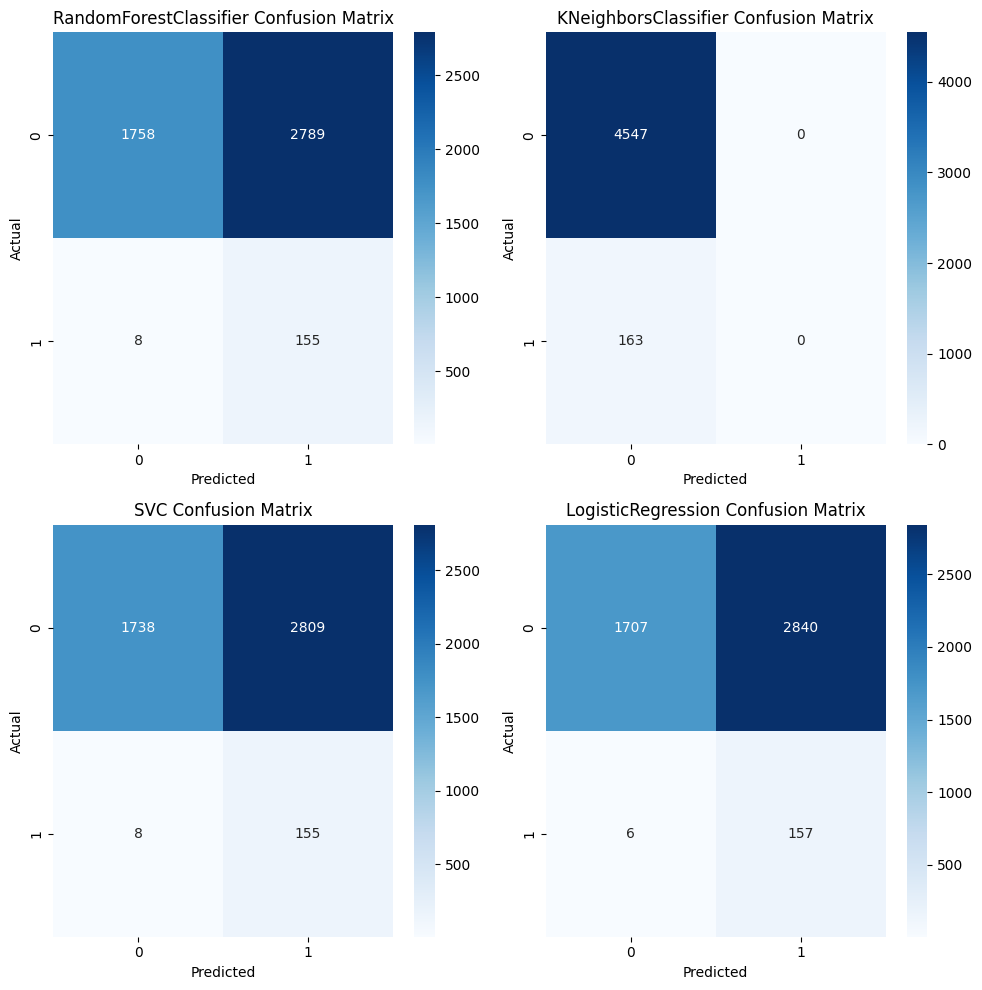

In [36]:
# Plot confusion matrix for each model in subplot
fig, axes= plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes= axes.flatten()
i= 0
for name, grid in results.items():
    y_pred= grid.best_estimator_.predict(X_test)
    cm= confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    # Set axes dyamically
    axes[i].set_title(f"{name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
    i+=1

plt.tight_layout()
plt.show()

In [37]:
# dataframe of metrics and models
metrics= {}
for name, grid in results.items():
    y_pred= grid.best_estimator_.predict(X_test)
    metrics[name]= {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=True),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }
    metrics_df= pd.DataFrame(metrics).T
metrics_df

,Accuracy,Precision,Recall,F1 Score
RandomForestClassifier,0.406157,0.052649,0.95092,0.099775
KNeighborsClassifier,0.965393,1.000000,0.00000,0.000000
SVC,0.401911,0.052294,0.95092,0.099137
LogisticRegression,0.395754,0.052386,0.96319,0.099367


C:\Users\Thistle\AppData\Local\Temp\ipykernel_2664\495869025.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\Thistle\AppData\Local\Temp\ipykernel_2664\495869025.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\Thistle\AppData\Local\Temp\ipykernel_2664\495869025.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\Thistle\AppData\Local\Temp\ipykernel_2664\495869025.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xtic

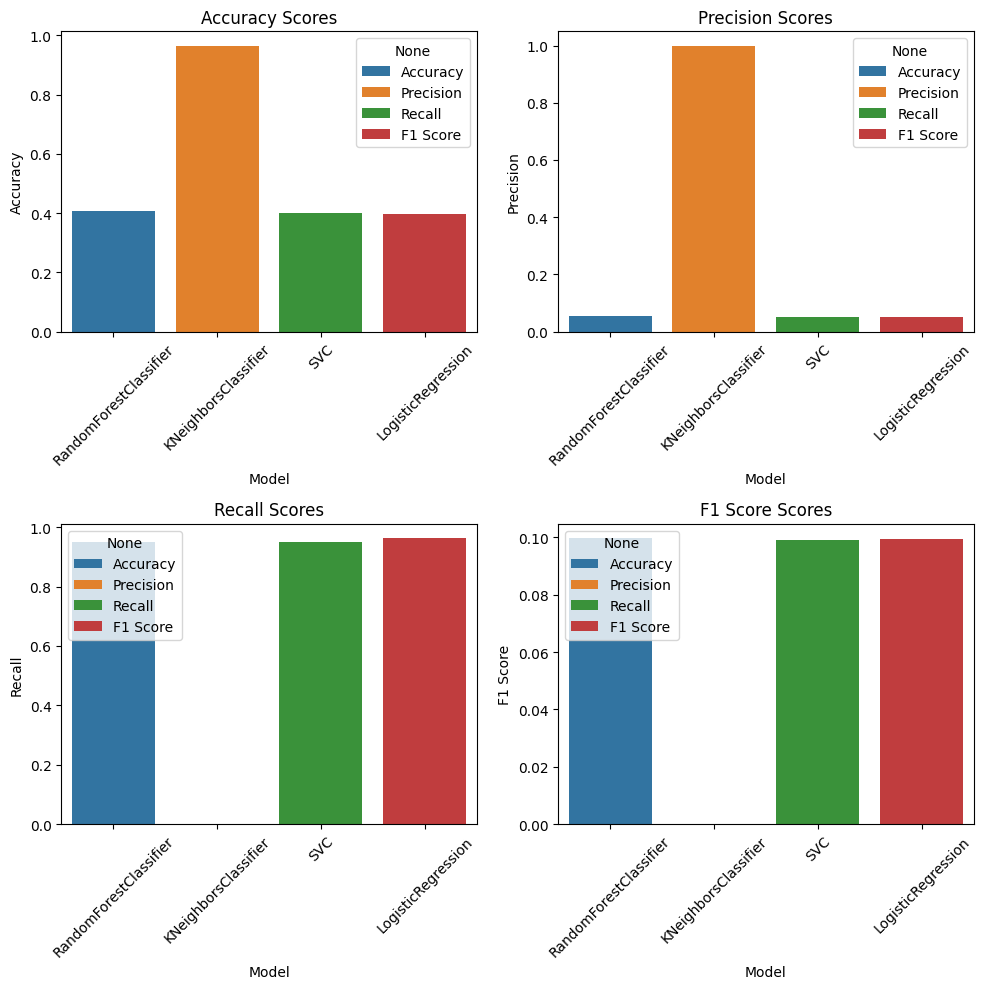

In [39]:
# Plot metrics for each model in subplot (2 rows)
fig, axes= plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes= axes.flatten()
i= 0
for metric in metrics_df.columns:
  sns.barplot(x=metrics_df.index, y=metrics_df[metric], ax=axes[i], hue= metrics_df.columns)
  axes[i].set_title(f"{metric} Scores")
  axes[i].set_xlabel("Model")
  # Adjust y limit for clearer comparison
  ymax= metrics_df[metric].max()+0.01
  # Limit ymax to 1
  if ymax > 1:
    ymax= 1
  axes[i].set_ylabel(metric)
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
  i+=1

plt.tight_layout()
plt.show()

In [40]:
# KNC is not behaving consistently
metrics_df= metrics_df.drop(["KNeighborsClassifier"], axis=0)
metrics_df

,Accuracy,Precision,Recall,F1 Score
RandomForestClassifier,0.406157,0.052649,0.95092,0.099775
SVC,0.401911,0.052294,0.95092,0.099137
LogisticRegression,0.395754,0.052386,0.96319,0.099367


In [41]:
# Selecting the best performing model by vote
binary_df = (metrics_df == metrics_df.max()).astype(int)
binary_df['total_score'] = binary_df.sum(axis=1)
best_model = binary_df['total_score'].idxmax()

print("Binary DataFrame:")
print(binary_df)
print("\nBest Model:", best_model)

Binary DataFrame:
                        Accuracy  Precision  Recall  F1 Score  total_score
RandomForestClassifier         1          1       0         1            3
SVC                            0          0       0         0            0
LogisticRegression             0          0       1         0            1

Best Model: RandomForestClassifier


In [45]:
# Saving the model

best_pipeline= results[best_model].best_estimator_
print(type(best_pipeline))
joblib.dump(best_pipeline, 'best_model_pipeline.pkl')

print("Best model pipeline saved!")

<class 'imblearn.pipeline.Pipeline'>
Best model pipeline saved!


In [43]:
# Saving categorical features to use as options in streamlit

regions= no_dupes_missing["REGION"].value_counts().index
tenures= no_dupes_missing["TENURE"].value_counts().index

joblib.dump(regions, "regions.pkl")
joblib.dump(tenures, "tenures.pkl")



['tenures.pkl']

In [46]:
X.columns

Index(['REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'ZONE1', 'ZONE2', 'REGULARITY', 'FREQ_TOP_PACK'],
      dtype='object')